In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from io import BytesIO
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import opendatasets as od
import zipfile

2024-01-04 17:48:12.738800: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 17:48:12.799937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 17:48:12.800370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 17:48:13.674449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
%matplotlib inline

### Load and prepare data

#### Load celebrity face dataset from kaggle
Executing the following cell downloads the celebrity faces dataset from Kaggle. You need to provide your username and API key after executing the cell.

In [4]:
#od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/download?datasetVersionNumber=2")

In [5]:
# with zipfile.ZipFile("celeba-dataset.zip","r") as zip_ref:
#     zip_ref.extractall("celeba-dataset")

In [6]:
attribute_path = "~/project_data/celeba-dataset/list_attr_celeba.csv"
partition_path = "~/project_data/celeba-dataset/list_eval_partition.csv"
images_path = "/home/ali/project_data/celeba-dataset/img_align_celeb/"
batch_size = 128
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"
image_size = (224, 224)

In [7]:
pwd

'/home/ali/projects/face-describer'

In [8]:
df_attributes = pd.read_csv(attribute_path)

In [9]:
df_attributes.head(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [10]:
df_attributes.columns.to_list()

['image_id',
 '5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [11]:
df_partition = pd.read_csv(partition_path)

In [12]:
df = pd.merge(df_attributes, df_partition, on="image_id")
df = df.replace(-1,0)
df.head(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [13]:
# Discard blurry images
df = df[df["Blurry"] ==0].copy()

In [14]:
selected_attributes = ["5_o_Clock_Shadow", "Bald", "Black_Hair", "Blond_Hair", "Brown_Hair",
                       "Eyeglasses", "Goatee", "Gray_Hair", "Male", "Mustache", "Smiling", "No_Beard",
                       "Wearing_Earrings", "Wearing_Hat"]

In [15]:
column_list = ["image_id"]
column_list.extend(selected_attributes)

In [16]:
df_attributes_selected = df[df.columns.intersection(column_list)].copy()

In [17]:
df_attributes_selected.head(5)

,image_id,5_o_Clock_Shadow,Bald,Black_Hair,Blond_Hair,Brown_Hair,Eyeglasses,Goatee,Gray_Hair,Male,Mustache,No_Beard,Smiling,Wearing_Earrings,Wearing_Hat
0,000001.jpg,0,0,0,0,1,0,0,0,0,0,1,1,1,0
1,000002.jpg,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,000004.jpg,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,000005.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,000006.jpg,0,0,0,0,1,0,0,0,0,0,1,0,1,0


#### Cleaning the data set

We need to clean the dataset to remove the following faulty instances:

- Instances where the person is not wearing a hat and is not bald, yet no hair colour is assigned.
- Instances where more than one hair colour is assigned to the person.

In [18]:
df_attributes_selected = df_attributes_selected.loc[~(df_attributes_selected["Blond_Hair"] + df_attributes_selected["Brown_Hair"] +df_attributes_selected["Black_Hair"] +df_attributes_selected["Gray_Hair"] > 1)].copy()

In [19]:
df_attributes_selected = df_attributes_selected.loc[~((df_attributes_selected["Blond_Hair"] + df_attributes_selected["Brown_Hair"] +df_attributes_selected["Black_Hair"] +df_attributes_selected["Gray_Hair"] == 0) & (df_attributes_selected["Wearing_Hat"] + df_attributes_selected["Bald"] == 0))].copy()

In [20]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3, dct_method="INTEGER_ACCURATE")
    image = tf.image.resize(image, image_size)
    return image

In [21]:
def load_and_preprocess_image(path, *args):
    image = tf.io.read_file(path)
    return preprocess_image(image), *args

In [22]:
def build_dataset_from_df(input_df, attr_list):
    b_list = [input_df[attr] for attr in attr_list]
    b_list.insert(0, [images_path + image_id for image_id in input_df["image_id"]])
    a_tuple = tuple(b_list)
    dataset = tf.data.Dataset.from_tensor_slices(a_tuple)
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.shuffle(buffer_size=1000)
    #TODO check the effect of dataset.repeat()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [23]:
train_df = df_attributes_selected.loc[df["partition"] == 0]
train_ds = build_dataset_from_df(train_df, selected_attributes)
val_df = df_attributes_selected.loc[df["partition"] == 1]
val_ds = build_dataset_from_df(val_df, selected_attributes)

2024-01-04 17:48:36.517152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [24]:
list(train_ds.take(1).as_numpy_iterator())

2024-01-04 17:48:36.895803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype int64 and shape [104066]
	 [[{{node Placeholder/_12}}]]
2024-01-04 17:48:36.896321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [104066]
	 [[{{node Placeholder/_4}}]]


[(array([[[[ 73.        ,  74.        ,  56.        ],
           [ 86.83929   ,  89.22321   ,  69.14732   ],
           [ 97.37946   , 100.37946   ,  79.37946   ],
           ...,
           [ 77.        ,  89.45981   ,  98.86603   ],
           [ 76.691956  ,  88.        ,  92.15173   ],
           [ 76.        ,  88.        ,  88.        ]],
  
          [[ 73.        ,  74.        ,  56.        ],
           [ 86.175125  ,  88.55905   ,  68.483154  ],
           [ 96.8867    ,  99.8867    ,  78.8867    ],
           ...,
           [ 77.49277   ,  89.952576  ,  98.37326   ],
           [ 77.65178   ,  88.95982   ,  91.78325   ],
           [ 76.95982   ,  88.95982   ,  88.95982   ]],
  
          [[ 72.06696   ,  73.06696   ,  55.066963  ],
           [ 85.85992   ,  88.24384   ,  68.16795   ],
           [ 96.41205   ,  99.41205   ,  78.41205   ],
           ...,
           [ 78.446434  ,  90.90624   ,  98.37763   ],
           [ 78.91241   ,  90.22045   ,  92.98827   ],
         

In [25]:
next_batch = next(iter(train_ds))
print (f"Image shape: {next_batch[0][1].numpy().shape}")
for i in range(len(selected_attributes)):
    print (f"{selected_attributes[i]} shape: {next_batch[i+1].shape}")

2024-01-04 17:48:38.501829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [104066]
	 [[{{node Placeholder/_10}}]]
2024-01-04 17:48:38.502687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [104066]
	 [[{{node Placeholder/_6}}]]


Image shape: (224, 224, 3)
5_o_Clock_Shadow shape: (128,)
Bald shape: (128,)
Black_Hair shape: (128,)
Blond_Hair shape: (128,)
Brown_Hair shape: (128,)
Eyeglasses shape: (128,)
Goatee shape: (128,)
Gray_Hair shape: (128,)
Male shape: (128,)
Mustache shape: (128,)
Smiling shape: (128,)
No_Beard shape: (128,)
Wearing_Earrings shape: (128,)
Wearing_Hat shape: (128,)


In [26]:
def text_to_rgba(some_str, *, dpi, **kwargs):
    fig = Figure(facecolor="none")
    fig.text(0, 0, some_str, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba_out = plt.imread(buf)
    return rgba_out

<Figure size 640x480 with 0 Axes>

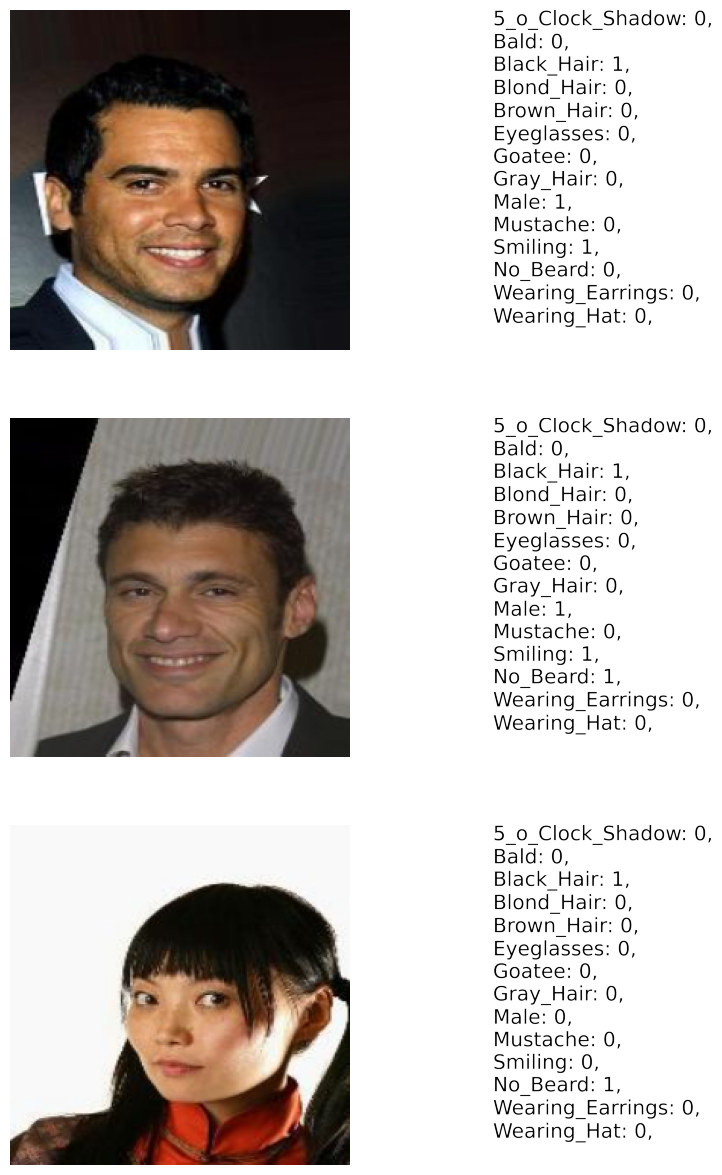

In [27]:
next_batch = next(iter(train_ds))
plt.tight_layout()
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    axs[i, 0].imshow(next_batch[0][i].numpy().astype("uint8"))
    axs[i, 0].axis("off")
    s = ""
    for j in range (len(selected_attributes)):
        s = s + f"{selected_attributes[j]}: {next_batch[j+1][i].numpy()},\n"
    rgba = text_to_rgba(s, color="black", fontsize=50, dpi=200)
    axs[i, 1].imshow(rgba)
    axs[i, 1].axis("off")

In [28]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))

In [29]:
def apply_preprocessing_model(images, *args):
    return (preprocessing_model(images), (args))

In [30]:
def apply_normalization_layer(images, *args):
    return (normalization_layer(images), (args))

In [31]:
train_ds = train_ds.map(apply_preprocessing_model)
val_ds = val_ds.map(apply_normalization_layer)

#### Create Model

In [32]:
do_fine_tuning = False
image_input = tf.keras.Input(shape=image_size + (3,))
en_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)(image_input)
en_model = tf.keras.layers.Dropout(rate=0.2)(en_model)
en_model = tf.keras.layers.Dense(128, activation="relu")(en_model)
output_layers = []
for attr in selected_attributes:
    output_layers.append(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name=f'{attr}')(en_model))

model = tf.keras.Model( inputs = image_input, outputs = output_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            

In [33]:
model.compile(
    loss = {f"{attr}": tf.keras.losses.BinaryCrossentropy() for attr in selected_attributes},
    metrics = {f"{attr}": [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] for attr in selected_attributes},
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

#### Train model

In [34]:
len(train_df) // batch_size

813

In [35]:
len(val_df) // batch_size

100

In [41]:
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
813/813 [==============================] - 2555s 3s/step - loss: 2.1302 - 5_o_Clock_Shadow_loss: 0.1932 - Bald_loss: 0.0380 - Black_Hair_loss: 0.1827 - Blond_Hair_loss: 0.1204 - Brown_Hair_loss: 0.2561 - Eyeglasses_loss: 0.0356 - Goatee_loss: 0.1196 - Gray_Hair_loss: 0.0540 - Male_loss: 0.0947 - Mustache_loss: 0.1085 - Smiling_loss: 0.3907 - No_Beard_loss: 0.1841 - Wearing_Earrings_loss: 0.3217 - Wearing_Hat_loss: 0.0282 - 5_o_Clock_Shadow_precision: 0.6559 - 5_o_Clock_Shadow_recall: 0.4249 - Bald_precision_1: 0.8295 - Bald_recall_1: 0.7215 - Black_Hair_precision_2: 0.8912 - Black_Hair_recall_2: 0.8962 - Blond_Hair_precision_3: 0.9018 - Blond_Hair_recall_3: 0.8747 - Brown_Hair_precision_4: 0.8282 - Brown_Hair_recall_4: 0.7937 - Eyeglasses_precision_5: 0.9454 - Eyeglasses_recall_5: 0.8712 - Goatee_precision_6: 0.6570 - Goatee_recall_6: 0.4332 - Gray_Hair_precision_7: 0.8686 - Gray_Hair_recall_7: 0.7879 - Male_precision_8: 0.9569 - Male_recall_8: 0.9560 - Mustache_precision_9: 

#### Make predictions

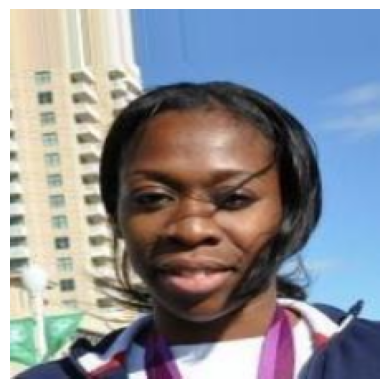

1/1 [==============================] - 0s 65ms/step
5_o_Clock_Shadow: actual 0, predicted 0 (0.0033)
Bald: actual 0, predicted 0 (0.0124)
Black_Hair: actual 1, predicted 1 (0.8302)
Blond_Hair: actual 0, predicted 0 (0.0090)
Brown_Hair: actual 0, predicted 0 (0.0318)
Eyeglasses: actual 0, predicted 0 (0.0859)
Goatee: actual 0, predicted 0 (0.0027)
Gray_Hair: actual 0, predicted 0 (0.1249)
Male: actual 0, predicted 0 (0.3225)
Mustache: actual 0, predicted 0 (0.0184)
Smiling: actual 1, predicted 1 (0.9811)
No_Beard: actual 1, predicted 1 (0.9853)
Wearing_Earrings: actual 0, predicted 0 (0.0864)
Wearing_Hat: actual 0, predicted 0 (0.0002)


In [44]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(selected_attributes):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

In [45]:
image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.9333334 , 0.87843144, 0.73333335],
        [0.94147414, 0.8865722 , 0.74147415],
        [0.94891465, 0.8863796 , 0.7431898 ],
        ...,
        [0.3921569 , 0.5803922 , 0.8235295 ],
        [0.3921569 , 0.5803922 , 0.8235295 ],
        [0.3921569 , 0.5803922 , 0.8235295 ]],

       [[0.9333334 , 0.87843144, 0.73333335],
        [0.94147414, 0.8865722 , 0.74147415],
        [0.94891465, 0.8863796 , 0.7431898 ],
        ...,
        [0.3921569 , 0.5803922 , 0.8235295 ],
        [0.3921569 , 0.5803922 , 0.8235295 ],
        [0.3921569 , 0.5803922 , 0.8235295 ]],

       [[0.9333334 , 0.87843144, 0.73333335],
        [0.94147414, 0.8865722 , 0.74147415],
        [0.94891465, 0.8863796 , 0.7431898 ],
        ...,
        [0.3921569 , 0.5803922 , 0.8235295 ],
        [0.3921569 , 0.5803922 , 0.8235295 ],
        [0.3921569 , 0.5803922 , 0.8235295 ]],

       ...,

       [[0.9524331 , 0.89910656, 0.88734186],
        [0.95

In [43]:
!mkdir -p saved_model
model.save('saved_model/my_model_tflite_compatible')

2024-01-04 21:13:29.736068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2024-01-04 21:13:31.531385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: saved_model/my_model_tflite_compatible/assets


INFO:tensorflow:Assets written to: saved_model/my_model_tflite_compatible/assets
